### Objective:

To classify Happy or Sad Emotions in Musical Audio Files using deep learning. Essentially, it a binary classification problem.

### Problem Statement

To build and implement a deep learning model to classify Happy or Sad Emotions in Musical Audio Files dataset.

At the end of this competition, you will be able to:

Load and extract features of wave files available in the Musical Audio Files dataset using librosa.feature.mfcc, Mel-spectogram, STFT (Short-time Fourier Transform) etc..

Build a deep learning model using either Keras or PyTorch deep learning libraries.

### Description:

Dataset Description: The original dataset contains 7 classes but this is just a subset of the original dataset which contains 2 classes. The audio files in the dataset were already preprocessed by converting them into smaller chunks of equal size. All music were divided into 10 seconds smaller chunks using FFMPEG.

The chunks of the same song have the equally spaced names like : Happy20001-Happy20016(Same song) The last two digits resembles the chunk number while the first three digits are the ID of the original song which is provided as the GroupID. The two classes are: 1.)Happy and 2.)Sad

Here is a handy link to Kaggle's competition documentation (https://www.kaggle.com/docs/competitions), which includes, among other things, instructions on submitting predictions (https://www.kaggle.com/docs/competitions#making-a-submission).

### Instructions for downloading train and test data are as follows:

### 1. Create an API key in Kaggle.

To do this, go to the competition site on Kaggle at https://www.kaggle.com/competitions/musical-emotions-classification-in-audio-files and open your user settings page. Click Account.

![alt text](https://i.stack.imgur.com/jxGQv.png)

### 2. Next, scroll down to the API access section and click generate to download an API key (kaggle.json). 
![alt text](https://i.stack.imgur.com/Hzlhp.png)

### 3. Upload your kaggle.json file using the following snippet in a code cell:



In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ranjitpatil","key":"db9db039c5a5c79e490047c3c58b8787"}'}

In [ ]:
#If successfully uploaded in the above step, the 'ls' command here should display the kaggle.json file.
%ls

kaggle.json  sample_data/


### 4. Install the Kaggle API using the following command


In [ ]:
!pip install -U -q kaggle==1.5.8

     |████████████████████████████████| 59 kB 4.6 MB/s 


### 5. Move the kaggle.json file into ~/.kaggle, which is where the API client expects your token to be located:



In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
#Execute the following command to verify whether the kaggle.json is stored in the appropriate location: ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json #run this command to ensure your Kaggle API token is secure on colab

### 6. Now download the Test Data from Kaggle

**NOTE: If you get a '404 - Not Found' error after running the cell below, it is most likely that the user (whose kaggle.json is uploaded above) has not 'accepted' the rules of the competition and therefore has 'not joined' the competition.**

If you encounter **401-unauthorised** download latest **kaggle.json** by repeating steps 1 & 2

In [ ]:
#If you get a forbidden link, you have most likely not joined the competition.
!kaggle competitions download -c musical-emotions-classification-in-audio-files
!unzip musical-emotions-classification-in-audio-files

100% 638M/641M [00:05<00:00, 135MB/s]
100% 641M/641M [00:05<00:00, 133MB/s]
Archive:  musical-emotions-classification-in-audio-files.zip
  inflating: Test/Test/1.wav         
  inflating: Test/Test/10.wav        
  inflating: Test/Test/100.wav       
  inflating: Test/Test/101.wav       
  inflating: Test/Test/102.wav       
  inflating: Test/Test/103.wav       
  inflating: Test/Test/104.wav       
  inflating: Test/Test/105.wav       
  inflating: Test/Test/106.wav       
  inflating: Test/Test/107.wav       
  inflating: Test/Test/108.wav       
  inflating: Test/Test/109.wav       
  inflating: Test/Test/11.wav        
  inflating: Test/Test/110.wav       
  inflating: Test/Test/111.wav       
  inflating: Test/Test/112.wav       
  inflating: Test/Test/113.wav       
  inflating: Test/Test/114.wav       
  inflating: Test/Test/115.wav       
  inflating: Test/Test/116.wav       
  inflating: Test/Test/117.wav       
  inflating: Test/Test/118.wav       
  inflating: Test/Test/119.

## Grading = 10 Points

### YOUR CODING STARTS FROM HERE

### Import Neccesary Packages

In [167]:
from pathlib import Path
from collections import Counter
from tqdm import tqdm
import librosa
import librosa.display
from IPython.display import display, Audio

from matplotlib import pyplot as plt
import numpy as np
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary

In [ ]:
import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

def warn(*args, **kwargs):
    pass
warnings.warn = warn

### **Stage 1:** Load the Train data audio files (1 point)




In [ ]:
# Function to get the .wav files and Map the labels for each wav file
def get_files(path, extension='.wav'):
    return list(path.rglob(f'*{extension}'))

In [ ]:
train_data_path = 'Train/Train/'

In [ ]:
# Get all files from the Train data folders
train_files = get_files(Path(train_data_path))
print(len(train_files))

1873


In [ ]:
# Assigning labels to each .wav file in all the folders
# Note: the label id starts from 0 to 1
label_id = {"Hap": 0, 'Sad': 1}
label_id_rev = {0: "Happy", 1: 'Sad'}
labels = {str(l):label_id[l.stem.split('/')[0][:3]] for l in train_files}
print(len(labels))

1873


In [ ]:
# labels

In [ ]:
test_data_path = 'Test/Test/'

In [ ]:
# Get all files from the Train data folders
test_files = get_files(Path(test_data_path))
print(len(test_files))

253


In [ ]:
all_files = train_files + test_files
print(len(all_files))

2126


#### Play the sample audio

In [ ]:
happy_sample_path = 'Train/Train/Happy/Happy10200.wav'

Audio(happy_sample_path)

In [ ]:
sad_sample_path = 'Train/Train/Sad/Sad12907.wav'

Audio(sad_sample_path)

### **Stage 2:** Data Exploration and Visualization (1 point)


*  Find count of each label and plot bar graph



In [ ]:
count = Counter(labels.values())
count

Counter({0: 828, 1: 1045})

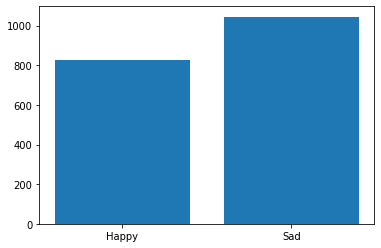

In [ ]:
keys = list(count.keys())
keys = [label_id_rev[k] for k in keys]
values = list(count.values())

plt.bar(keys, values)
plt.show()

#### Visualize sample audio signal using librosa

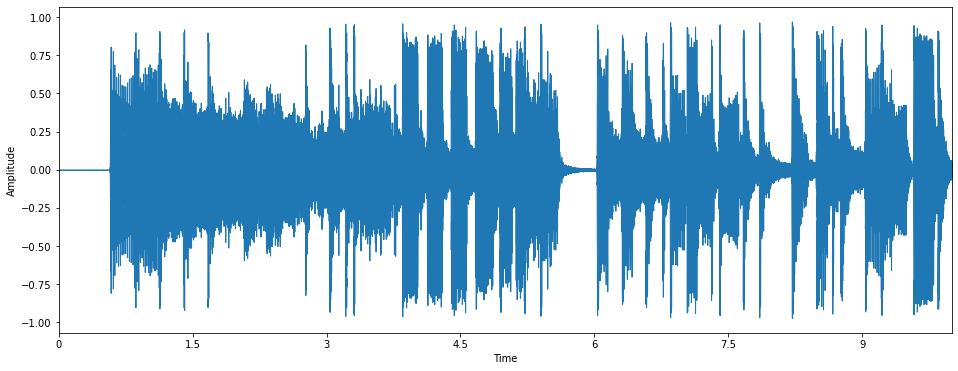

In [ ]:
signal, sr = librosa.load(happy_sample_path)

plt.figure(figsize=(16,6))
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

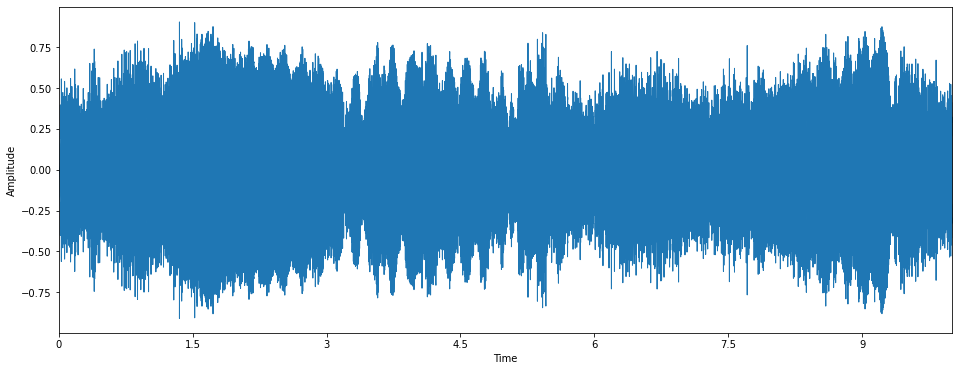

In [ ]:
signal, sr = librosa.load(sad_sample_path)

plt.figure(figsize=(16,6))
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### **Stage 3:** Feature extraction (2 points)


In [ ]:
# Constant Parameters
SAMPLE_RATE = 22050
N_FFT = 2048
HOP_LEN = 512
N_MFCC = 13

Shape of spectrogram: (431, 13)


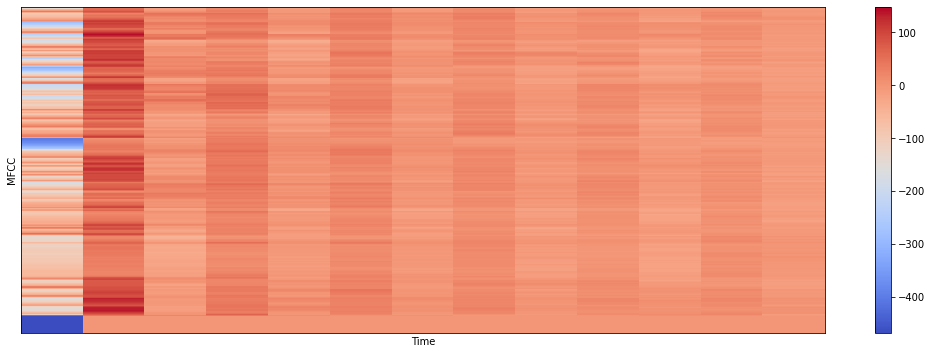

In [182]:
# Transform one of our example waveforms into a spectrogram and visualize the result:
signal, sr = librosa.load(happy_sample_path, sr=SAMPLE_RATE)
mfcc = librosa.feature.mfcc(signal,
                            sr=SAMPLE_RATE,
                            n_fft=N_FFT,
                            hop_length=HOP_LEN,
                            n_mfcc=N_MFCC).T

print(f"Shape of spectrogram: {mfcc.shape}")

plt.figure(figsize=(18,6))
librosa.display.specshow(mfcc, sr=SAMPLE_RATE, hop_length=HOP_LEN)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

In [183]:
# Prepare the Emotion dataset
class EmotionDataset(Dataset):
    def __init__(self, mode, labels):
        self.mode = mode
        if self.mode == "train" or self.mode == "val":
            file_names = [l for l in labels if l.split('/')[-1]]

            self.file_names = file_names
            self.label_dict = labels
        
        elif self.mode == "test":
            self.file_names = labels

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):  
        """Function Extracts Features from WAV(aduio) file"""   
        # Load an audio file as a floating point time series
        # which returns audio time series and sampling rate of y  
        signal, sr = librosa.load(self.file_names[idx], sr=SAMPLE_RATE)
        # Mel-frequency cepstral coefficients (MFCCs), represents the short-term power spectrum of a sound
        # number of MFCCs to return is 13 over each time frame
        mfcc = librosa.feature.mfcc(signal,
                                sr=SAMPLE_RATE,
                                n_fft=N_FFT,
                                hop_length=HOP_LEN,
                                n_mfcc=N_MFCC).T
        
        if self.mode == "train" or self.mode == "val":
            return torch.from_numpy(mfcc), self.label_dict[self.file_names[idx]]
        
        elif self.mode == "test":
            return torch.from_numpy(mfcc), self.file_names[idx]

class BatchPadCollafeFn():
     """ padding sequential data to max length of a batch.
     Zero-pads model inputs and targets based on number of frames per step """
     def __init__(self):
        pass
     
     def __call__(self, batch):
        # zero-pad all audio signals to max input length
        input_lengths, ids_sorted_decreasing = torch.sort(
            torch.LongTensor([len(x[0]) for x in batch]),
            dim=0, descending=True)
        max_input_len = input_lengths[0]
        mfcc_padded = torch.FloatTensor(len(batch), max_input_len, batch[ids_sorted_decreasing[0]][0].shape[-1])
        mfcc_padded.zero_()
        labels = torch.LongTensor(len(batch))
        
        for i in range(len(ids_sorted_decreasing)):
            mfcc = batch[ids_sorted_decreasing[i]][0]
            mfcc_padded[i, :mfcc.shape[0], :] = mfcc
            labels[i] = batch[ids_sorted_decreasing[i]][1]

        return mfcc_padded, labels

Loading the dataset

In [184]:
# Random split of 80:20 between training and validation
dataset = EmotionDataset(mode='train', labels=labels)

num_items = len(dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
traindataset, valdataset = random_split(dataset, [num_train, num_val])

In [185]:
print(len(traindataset), len(valdataset))

1498 375


In [186]:
BATCH_SIZE = 16

# A custom collate_fn can be used to customize collation, e.g., padding sequential data to max length of a batch
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, collate_fn=BatchPadCollafeFn(), shuffle=True)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, collate_fn=BatchPadCollafeFn(), shuffle=False)

In [187]:
# Get shape of batch
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([16, 432, 13])
Labels batch shape: torch.Size([16])


### **Stage 4:** Train the model  (3 points)


In [188]:
# conv1 = nn.Sequential(
#     nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=2),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2)
# )
# conv2 = nn.Sequential(
#     nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=2),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2)
# )
# conv3 = nn.Sequential(
#     nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=2),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2)
# )
# conv4 = nn.Sequential(
#     nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=2),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2)
# )
# flatten = nn.Flatten()
# linear1 = nn.Linear(in_features=128*2*28,out_features=128)
# linear2 = nn.Linear(in_features=128,out_features=1)
# output = nn.Sigmoid()


# X = train_features
# # X = train_features.type(torch.LongTensor)
# print(X.size())

# out = X.permute(0, 2, 1)
# print(out.size())
# out = out[:, np.newaxis, :]   
# print(out.size())
# out = out.type(torch.FloatTensor)
# print(type(out))

# out = conv1(out)
# print(out.size())
# out = conv2(out)
# print(out.size())
# out = conv3(out)
# print(out.size())
# out = conv4(out)
# print(out.size())
# out = flatten(out)
# print(out.size())
# out = linear1(out)
# print(out.size())
# logits = linear2(out)
# print(out.size())
# output = output(logits)
# print(out.size())

In [189]:
# # With square kernels and equal stride
# m = nn.Conv2d(1, 32, 3, stride=2, padding=1)
# input = torch.randn(16, 432, 13)
# print(input.size())
# input = input.permute(0, 2, 1)
# print(input.size())
# input = input[:,np.newaxis,:]
# print(input.size())
# output = m(input)
# print(output.size())

In [190]:
# Define the model
class CNNNetwork(nn.Module):
    def __init__(self, in_channel=13):
        super().__init__()

        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten=nn.Flatten()
        self.linear1=nn.Linear(in_features=128*2*28, out_features=128)
        self.linear2=nn.Linear(in_features=128, out_features=1)
        self.output=nn.Sigmoid()
        

    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = out[:, np.newaxis, :]   

        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.flatten(out)
        out = self.linear1(out)
        logits = self.linear2(out)
        out = self.output(logits)

        return out

In [191]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [192]:
# Define train and test functions
def train(loader, model, device):
    model.train()
    model = model.to(device)
   
    # Binary Cross entropy as loss function
    lossfn = nn.BCELoss()

    losses = []
    accuracies = []

    # iter = 1
    for data, label in tqdm(loader):
        # Convert data and labels to torch tensor
        data, label = data.type(torch.FloatTensor), label.type(torch.FloatTensor)

        data, label = data.to(device), label.to(device)

        # Pass the data through the model
        y_pred = model(data)

        # Calculate the loss
        loss = lossfn(y_pred, label.view(-1,1))
        accuracy = binary_acc(y_pred, label.unsqueeze(1))

        # Zero out the gradients
        optimiser.zero_grad()

        # Do backpropagation
        loss.backward()

        # Update the weights accordingly
        optimiser.step()
        
        losses.append(loss.item())
        accuracies.append(accuracy.item())

        # print(f'Iteration {iter+0:03}: | Training Loss: {sum(losses)/len(losses):.5f} | Training Acc: {sum(accuracies)/len(loader):.3f}')
        # iter += 1

    return sum(losses)/len(losses), sum(accuracies)/len(loader)

In [193]:
def val(loader):
    # Keep the model to evaluation mode
    model.eval()
    lossfn = nn.BCELoss()
    losses = []
    accuracies = []
    # iter = 1
    for data, label in tqdm(loader):
        # Convert data and labels to torch tensor
        data, label = data.type(torch.FloatTensor), label.type(torch.FloatTensor)
        data, label = data.to(device), label.to(device)
        y_pred = model(data)
        loss = lossfn(y_pred, label.view(-1,1))
        accuracy = binary_acc(y_pred, label.unsqueeze(1))
        losses.append(loss.item())
        accuracies.append(accuracy.item())

        # print(f'Iteration {iter+0:03}: | Validation Loss: {sum(losses)/len(losses):.5f} | Validation Acc: {sum(accuracies)/len(loader):.3f}')
        # iter += 1

    return sum(losses)/len(losses), sum(accuracies)/len(loader)

In [194]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.0001 # Learning rate
model = CNNNetwork().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer

In [195]:
device

device(type='cuda')

In [196]:
# [i.device for i in model.parameters()]

In [197]:
summary(model, (432,13))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 15, 434]             160
              ReLU-2          [-1, 16, 15, 434]               0
         MaxPool2d-3           [-1, 16, 7, 217]               0
            Conv2d-4           [-1, 32, 9, 219]           4,640
              ReLU-5           [-1, 32, 9, 219]               0
         MaxPool2d-6           [-1, 32, 4, 109]               0
            Conv2d-7           [-1, 64, 6, 111]          18,496
              ReLU-8           [-1, 64, 6, 111]               0
         MaxPool2d-9            [-1, 64, 3, 55]               0
           Conv2d-10           [-1, 128, 5, 57]          73,856
             ReLU-11           [-1, 128, 5, 57]               0
        MaxPool2d-12           [-1, 128, 2, 28]               0
          Flatten-13                 [-1, 7168]               0
           Linear-14                  [

In [198]:
print(model)

CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=7168, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (

In [199]:
num_epochs = 5
trainloss, trainaccs, valloss, valaccs = [], [], [], []
for ep in range(num_epochs):
    loss, accs = train(trainloader, model, device)
    trainloss.append(loss)
    trainaccs.append(accs)
    loss, accs = val(valloader)
    valloss.append(loss)
    valaccs.append(accs)
    # To print the validation, training loss and validation, training accuracy  
    print(f'\nEpoch {ep+1:03}: | Training Loss: {trainloss[-1]:.5f} | Training Acc: {trainaccs[-1]:.3f}')
    print(f'Epoch {ep+1:03}: | Validation Loss: {valloss[-1]:.5f} | Validation Acc: {valaccs[-1]:.3f}')

100%|██████████| 24/24 [02:36<00:00,  6.50s/it]



Epoch 001: | Training Loss: 1.18758 | Training Acc: 63.117
Epoch 001: | Validation Loss: 0.57068 | Validation Acc: 72.833


100%|██████████| 24/24 [02:49<00:00,  7.08s/it]



Epoch 002: | Training Loss: 0.55125 | Training Acc: 72.340
Epoch 002: | Validation Loss: 0.54714 | Validation Acc: 74.583


100%|██████████| 24/24 [02:45<00:00,  6.90s/it]



Epoch 003: | Training Loss: 0.53406 | Training Acc: 74.021
Epoch 003: | Validation Loss: 0.54698 | Validation Acc: 72.500


100%|██████████| 24/24 [02:36<00:00,  6.53s/it]



Epoch 004: | Training Loss: 0.51813 | Training Acc: 73.819
Epoch 004: | Validation Loss: 0.53348 | Validation Acc: 74.750


100%|██████████| 24/24 [02:48<00:00,  7.03s/it]


Epoch 005: | Training Loss: 0.46974 | Training Acc: 79.128
Epoch 005: | Validation Loss: 0.49692 | Validation Acc: 76.917


In [200]:
# Print metrics
print(f'Training Accuracy   : {trainaccs[-1]}')
print(f'Validation Accuracy : {valaccs[-1]}')
print(f'Training Loss       : {trainloss[-1]}')
print(f'Validation Loss     : {valloss[-1]}')

Training Accuracy   : 79.12765957446808
Validation Accuracy : 76.91666666666667
Training Loss       : 0.46974245855148805
Validation Loss     : 0.49692196647326153


In [201]:
!mkdir -p /content/models

In [202]:
# Save model
torch.save(model.state_dict(),'models/model1.pth')

In [203]:
# Load model
model.load_state_dict(torch.load('models/model1.pth'))

<All keys matched successfully>

In [204]:
# def plot_training_hist(history):
#     '''Function to plot history for accuracy and loss'''
    
#     fig, ax = plt.subplots(1, 2, figsize=(10,4))
#     # first plot
#     ax[0].plot(history.history['accuracy'])
#     ax[0].plot(history.history['val_accuracy'])
#     ax[0].set_title('Model Accuracy')
#     ax[0].set_xlabel('epoch')
#     ax[0].set_ylabel('accuracy')
#     ax[0].legend(['train', 'validation'], loc='best')
#     # second plot
#     ax[1].plot(history.history['loss'])
#     ax[1].plot(history.history['val_loss'])
#     ax[1].set_title('Model Loss')
#     ax[1].set_xlabel('epoch')
#     ax[1].set_ylabel('loss')
#     ax[1].legend(['train', 'validation'], loc='best')

In [205]:
# # Visualization of Training and Validation Accuracy
# plot_training_hist(trainaccc)

### **Stage 5:** Kaggle Testset predictions (3 points)



*   Load the test set and extract the features of the .wav files
*   Using the trained model get the predicions on the test set
*   Finally, upload your predictions to the kaggle



In [206]:
# test_files

In [207]:
# Loop through all audio files and transform each one into a spectrogram
spectrograms = []
for i in test_files:
    signal, sr = librosa.load(i, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(signal,
                                sr=SAMPLE_RATE,
                                n_fft=N_FFT,
                                hop_length=HOP_LEN,
                                n_mfcc=N_MFCC).T
    spectrograms.append(mfcc)
    mfcc = torch.from_numpy(mfcc)

In [217]:
# Look at a couple of examples of their shapes
spectrograms[0].shape, spectrograms[1].shape, spectrograms[2].shape

((430, 13), (431, 13), (431, 13))

In [218]:
# Get maximum heights and widths for all the spectrograms:
max_width, max_height = max([i.shape[0] for i in spectrograms]), max([i.shape[1] for i in spectrograms])
max_width, max_height

(432, 13)

In [219]:
spectrograms_padded = torch.FloatTensor(len(test_files), max_width, max_height)
spectrograms_padded.zero_()
for i in range(len(test_files)):
    mfcc = spectrograms[i][:]
    mfcc = torch.from_numpy(mfcc)
    spectrograms_padded[i, :mfcc.shape[0], :] = mfcc

In [220]:
spectrograms_padded.shape

torch.Size([253, 432, 13])

In [221]:
model.to(device)

CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=7168, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (

In [222]:
def predict(model, inputs):
    # Keep the model to evaluation mode
    model.eval()
    inputs = torch.unsqueeze(inputs,0)
    
    with torch.no_grad():
        predictions=model(inputs)

    return np.round(predictions.item())

In [223]:
# Get predictions
predictions = []
for i in range(spectrograms_padded.shape[0]):
    test_sample = spectrograms_padded[i,:,:]
    test_sample = test_sample.to(device)
    pred = predict(model=model, inputs=test_sample)
    predictions.append(pred)

In [224]:
# Get corresponding label for prediction
predictions_class = [label_id_rev.get(item, item)  for item in predictions]

In [225]:
# Get file names
test_file_names = [l.name for l in test_files]

In [226]:
# Prepare data for submission
submission_data = pd.DataFrame(list(zip(test_file_names, predictions_class)), columns=['File Name', 'Target'])
submission_data.sort_values('File Name', inplace=True)

In [227]:
submission_data

,File Name,Target
33,1.wav,Sad
23,10.wav,Happy
202,100.wav,Happy
126,101.wav,Happy
200,102.wav,Happy
...,...,...
86,95.wav,Happy
154,96.wav,Happy
247,97.wav,Happy
77,98.wav,Happy


In [228]:
# Prepare csv file
submission_data.to_csv("submission_data.csv", index=False)